In [1]:
from string2string.distance import LevenshteinEditDistance
from rwse import RWSE_Checker
from util.helper import check_token
from transformers import AutoTokenizer

import os
import pandas as pd
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
nlp = spacy.load('en_core_web_sm')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

## Cleaning

In [3]:
collection = dict()
with open('input/dataset_semantic_en_simple.txt', 'r') as f:
    result = []
    idx = 0
    for line in f:
        if line == "\n":
            collection[idx] = result
            idx += 1
            result = []
        else:
            result.append(line.strip())

len(collection)

448

In [4]:
collection[0]

['27',
 '1298315',
 'goals',
 'jails',
 '223',
 'Often they were sent away to the British Colonies in America. But in 1770, the colonies in America became the United States. They were free from British rule and would not take England s convicts any more. By the 1780s the goals of England were so full that convicts were often chained up in rotting old ships.The Government decided to make a settlement in New South Wales and send some of the convicts there. In 1788 the First Fleet of eleven ships set sail from Portsmouth carrying convicts, sailors, marines, a few free settlers and enough food to last for two years. Their leader was Captain Arthur Phillip.']

In [5]:
file_name = 'input/cleaned_dataset_semantic_en.csv'

def clean_text(text):
    text = '. '.join([part.strip() for part in text.split('.')]).strip()
    text = '. '.join([part.strip() for part in text.split('?')]).strip()
    return text

def find_sentence(token_text, token_start, text):
    tmp_doc = nlp(clean_text(text))
    for sent in tmp_doc.sents:
        if sent.start_char <= token_start < sent.end_char:
            for tmp_token in sent:
                if tmp_token.text == token_text:
                    tmp_start = tmp_token.idx - sent.start_char
                    tmp_end = tmp_start + len(tmp_token.text)
                    return sent.text[:tmp_start] + '[MASK]' + sent.text[tmp_end:]
    return None

if not os.path.exists(file_name):

    checkpoint = 'bert-base-cased'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    edit_distance = LevenshteinEditDistance()

    cleaned_collection_semantic = []
    bad_words = []
    bad_indices = []
    for key, value in collection.items():
        item = {
            'org_index': int(value[1]),
            'org_token': value[2],
            'org_suggestion': value[3],
            'confusion_set': f'{",".join(sorted([value[2],value[3]]))}',
            'levenshtein': edit_distance.compute(value[2], value[3]),
            'text': find_sentence(value[2], int(value[4]), ' '.join(value[5:]))
        }
        if check_token(tokenizer, item['org_token']) is None:
            bad_words.append(item['org_token'])
        elif check_token(tokenizer, item['org_suggestion']) is None:
            bad_words.append(item['org_suggestion'])
        elif item['text'] is None:
            bad_indices.append(item['org_index'])
        else:
            cleaned_collection_semantic.append(item)


    cleaned_collection_semantic = pd.DataFrame.from_dict(cleaned_collection_semantic)
    for confusion_set in cleaned_collection_semantic['confusion_set'].unique():
        indices = cleaned_collection_semantic[cleaned_collection_semantic['confusion_set'] == confusion_set].index
        if len(indices) == 2:
            cleaned_collection_semantic.drop(min(indices), inplace=True)
    cleaned_collection_semantic.to_csv(file_name, index=False, sep='\t')
    pd.DataFrame(bad_words).to_csv(file_name+'-bad_words', index=False, header=None, sep='\t')
    pd.DataFrame(bad_indices).to_csv(file_name+'-bad_indices', index=False, header=None, sep='\t')
else:
    cleaned_collection_semantic = pd.read_csv(file_name, sep='\t')

cleaned_collection_semantic

,org_index,org_token,org_suggestion,confusion_set,levenshtein,text
0,208822,were,wear,"wear,were",2.0,"When dancing ballet, you are required to [MASK..."
1,524374,affect,effect,"affect,effect",1.0,The Atlantic has a large [MASK] in the north a...
2,1137524,website,websites,"website,websites",1.0,Google is one of the biggest and most famous [...
3,16804,work,word,"word,work",1.0,"Its name comes from the Greek [MASK] for Sun, ..."
4,321273,main,major,"main,major",3.0,"In many countries throughout history, religion..."
...,...,...,...,...,...,...
133,1002353,easy,east,"east,easy",1.0,The [MASK] mainly spoke the Greek language.
135,1150628,honey,money,"honey,money",1.0,People who had bad things happen to them or wh...
136,502090,park,part,"park,part",1.0,The electrode is made of the same kind of meta...
137,1109051,saxophone,saxophonist,"saxophone,saxophonist",3.0,"Charlie Parker born August 29, 1920 in Kansas ..."


## Analysis

In [6]:
file_name = 'output/report_dataset_semantic_en.csv'

if not os.path.exists(file_name):
    with (open(file_name, 'w') as f):
        print('result', 'index' ,'org_token', 'org_suggestion', 'levenshtein', 'masked_sentence', 'certainty', sep='\t', end='\n', file=f)
        for index, item in cleaned_collection_semantic.iterrows():
            token = item['org_token']
            sentence = item['text']
            rwse.set_confusion_sets([item['confusion_set'].split(',')])
            suggestion, certainty = rwse.check(token, sentence)
            classification_result = 'TP' if suggestion == item['org_suggestion'] else 'FN'

            print(classification_result, item['org_index'], item['org_token'], item['org_suggestion'], item['levenshtein'], sentence, f'{certainty:.8f}', sep='\t', end='\n', file=f)

classification_results = pd.read_csv(file_name, sep='\t')
classification_results

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
0,TP,208822,were,wear,2.0,"When dancing ballet, you are required to [MASK...",0.926114
1,TP,524374,affect,effect,1.0,The Atlantic has a large [MASK] in the north a...,0.014813
2,FN,1137524,website,websites,1.0,Google is one of the biggest and most famous [...,0.008790
3,TP,16804,work,word,1.0,"Its name comes from the Greek [MASK] for Sun, ...",0.961607
4,TP,321273,main,major,3.0,"In many countries throughout history, religion...",0.474369
...,...,...,...,...,...,...,...
101,TP,1002353,easy,east,1.0,The [MASK] mainly spoke the Greek language.,0.000018
102,TP,1150628,honey,money,1.0,People who had bad things happen to them or wh...,0.151052
103,TP,502090,park,part,1.0,The electrode is made of the same kind of meta...,0.945280
104,FN,1109051,saxophone,saxophonist,3.0,"Charlie Parker born August 29, 1920 in Kansas ...",0.227890


In [7]:
print('sensitivity', len(classification_results[classification_results['result'] == 'TP'])/len(classification_results))

sensitivity 0.6132075471698113


In [8]:
for value in sorted(classification_results['levenshtein'].unique()):
    current_df = classification_results[classification_results['levenshtein'] == value]
    print('levenshtein', value, 'sensitivity', len(current_df[current_df['result'] == 'TP'])/len(current_df))

levenshtein 1.0 sensitivity 0.7142857142857143
levenshtein 2.0 sensitivity 0.6296296296296297
levenshtein 3.0 sensitivity 0.4864864864864865


### True-Positives

In [9]:
classification_results[classification_results['result'] == 'TP']

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
0,TP,208822,were,wear,2.0,"When dancing ballet, you are required to [MASK...",0.926114
1,TP,524374,affect,effect,1.0,The Atlantic has a large [MASK] in the north a...,0.014813
3,TP,16804,work,word,1.0,"Its name comes from the Greek [MASK] for Sun, ...",0.961607
4,TP,321273,main,major,3.0,"In many countries throughout history, religion...",0.474369
9,TP,343890,art,part,1.0,Leaving Canada Quebec was [MASK] of New France...,0.990314
...,...,...,...,...,...,...,...
100,TP,937722,stars,starts,1.0,After that it [MASK] to tumble and drop.,0.020662
101,TP,1002353,easy,east,1.0,The [MASK] mainly spoke the Greek language.,0.000018
102,TP,1150628,honey,money,1.0,People who had bad things happen to them or wh...,0.151052
103,TP,502090,park,part,1.0,The electrode is made of the same kind of meta...,0.945280


### False-Negatives

In [10]:
classification_results[classification_results['result'] == 'FN']

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
2,FN,1137524,website,websites,1.0,Google is one of the biggest and most famous [...,8.789750e-03
5,FN,143702,dancers,dancing,3.0,When people played instruments they were usual...,4.692000e-04
6,FN,341582,bitch,pitch,1.0,There are four things which music often has Mu...,9.500000e-07
7,FN,1250703,weed,wheat,3.0,One person who owned many cows could trade wit...,1.113100e-04
8,FN,620114,world,word,1.0,Where did the [MASK] come from.,1.692350e-03
11,FN,230095,need,use,3.0,Large measurements like the width of a galaxy ...,4.961000e-04
12,FN,656168,mile,milk,1.0,But still keeping the chocloate [MASK] away.,5.427000e-05
17,FN,113586,much,many,3.0,"The language has not changed [MASK] in 1,000 y...",9.361798e-01
19,FN,825462,weight,weigh,1.0,They no longer [MASK] the same.,2.550000e-06
20,FN,211968,steam,siege,3.0,Some of these machines were called catapults o...,3.355380e-02


## Magnitue Search

<Axes: >

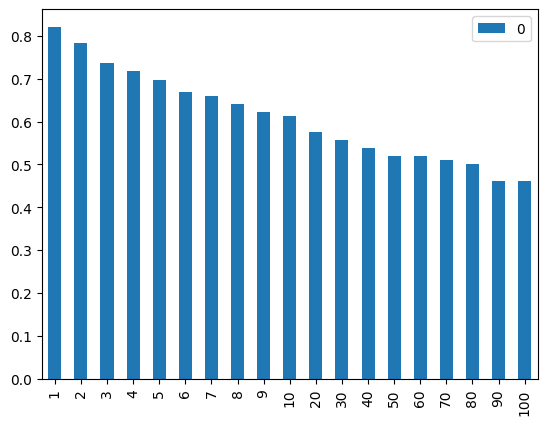

In [12]:
len_dataset = len(cleaned_collection_semantic)
magnitude_search = dict()
ranges = list(range(1, 10)) + list(range(10, 101, 10))
for i in ranges:
    count_TP = 0
    for index, item in cleaned_collection_semantic.iterrows():
        token = item['org_token']
        sentence = item['text']
        rwse.set_confusion_sets([item['confusion_set'].split(',')])
        suggestion, certainty = rwse.check(token, sentence, magnitude=i)
        if suggestion == item['org_suggestion']:
            count_TP += 1
    magnitude_search[i] = count_TP/len_dataset

pd.DataFrame.from_dict(magnitude_search, orient='index').plot(kind='bar')
#pd.DataFrame.from_dict(magnitude_search, orient='index').plot(kind='bar', subplots=True, layout=(1,2), figsize=(10,5))

<Axes: title={'center': 'model sensitivity by magnitude grouped by levenshtein edit distance'}>

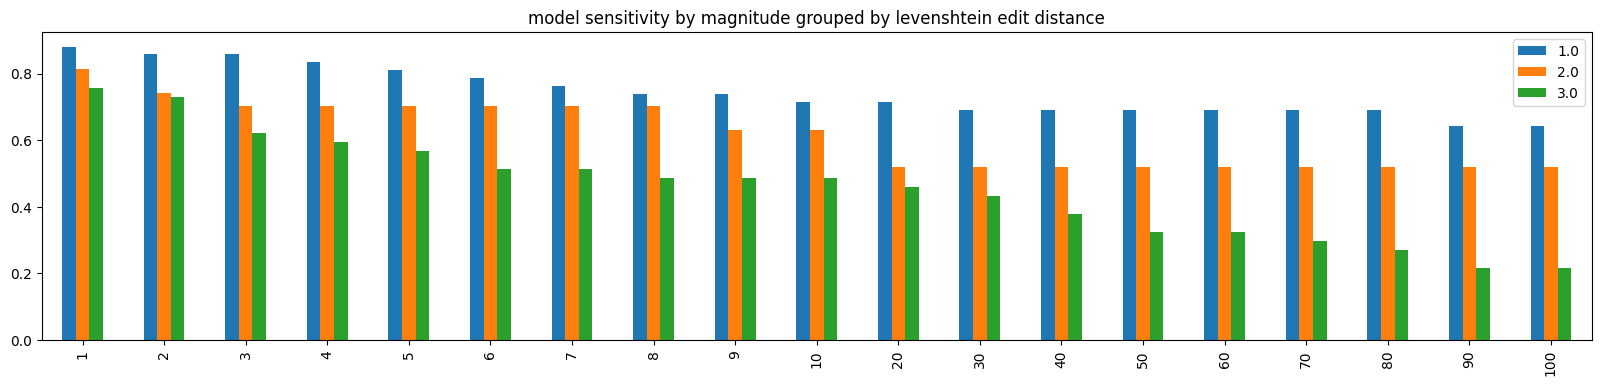

In [13]:
magnitude_search_dict = dict()
ranges = list(range(1, 10)) + list(range(10, 101, 10))
levenshtein_values = sorted(cleaned_collection_semantic['levenshtein'].unique())

for value in levenshtein_values:
    current_df = cleaned_collection_semantic[cleaned_collection_semantic['levenshtein'] == value]
    len_dataset = len(current_df)
    magnitude_search = dict()
    for i in ranges:
        count_TP = 0
        for index, item in current_df.iterrows():
            token = item['org_token']
            sentence = item['text']
            rwse.set_confusion_sets([item['confusion_set'].split(',')])
            suggestion, certainty = rwse.check(token, sentence, magnitude=i)
            if suggestion == item['org_suggestion']:
                count_TP += 1
        magnitude_search[i] = count_TP/len_dataset

    magnitude_search_dict[value] = magnitude_search.values()

tmp_df = pd.DataFrame({
    value: magnitude_search_dict[value] for value in levenshtein_values
}, index=ranges)
tmp_df.plot(kind="bar", figsize=(20,4), title=f'model sensitivity by magnitude grouped by levenshtein edit distance')
